# Identification of gene regulatory network from gene expression time-course data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("Assignment-gene-expression.csv",sep=";")
df.head()

,time,SWI5,CBF1,GAL4,GAL80,ASH1
0,0,0.0760,0.0419,0.0207,0.0225,0.1033
1,10,0.0186,0.0365,0.0122,0.0175,0.0462
2,20,0.0090,0.0514,0.0073,0.0165,0.0439
3,30,0.0117,0.0473,0.0079,0.0147,0.0371
4,40,0.0088,0.0482,0.0084,0.0145,0.0475


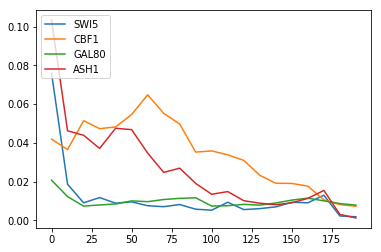

In [4]:
# Ploting the datas
t = df["time"]
plt.plot(t,df['SWI5'],label='SWI5')
plt.plot(t,df['CBF1'],label='CBF1')
plt.plot(t,df['GAL4'],label='GAL80')
plt.plot(t,df['ASH1'],label='ASH1')

plt.legend(loc='upper left')